#Imports and Variables

**Google-colabs:** https://colab.research.google.com/drive/19TUJHL5S6dVNajnW7zqVVChRxLz7vfhv?usp=sharing

In [11]:
import os
import glob
import shutil

import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import nn, optim
from PIL import Image
from torchvision.transforms import Resize
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
device = "cpu" #"cuda:0"

#Functions

In [17]:
class FetalPlaneDataset(Dataset):
    """Fetal Plane dataset."""

    def __init__(self,
                 root_dir,
                 csv_file,
                 plane=None,
                 brain_plane=None,
                 us_machine=None,
                 operator_number=None,
                 transform=None,
                 split_type=None,
                 split="train",
                 train_size=100,
                 downsampling_factor=2,
                 return_labels=False
                 ):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
            plane: 'Fetal brain'; 'Fetal thorax'; 'Maternal cervix'; 'Fetal femur'; 'Fetal thorax'; 'Other'
            brain_plane: 'Trans-ventricular'; 'Trans-thalamic'; 'Trans-cerebellum'
            us_machine: 'Voluson E6';'Voluson S10'
            operator_number: 'Op. 1'; 'Op. 2'; 'Op. 3';'Other'
            split_type (string, optional): Method to split dataset, supports "manual", and "csv"
            split (string): Which partition to return, supports "train", and "valid"
            train_size:  Limit dataset size to 100 images (for training)
            return_labels: Return the plane of the image

        return image, downsampled_image
        """
        self.transform = transform
        self.downsampling_factor = downsampling_factor
        self.root_dir = root_dir
        self.csv_file = pd.read_csv(csv_file, sep=';')
        self.return_labels = return_labels
        self.plane = plane

        if self.plane:
          self.csv_file = self.csv_file[self.csv_file['Plane'] == self.plane]
          if self.plane == 'Fetal brain':
            self.csv_file = self.csv_file[self.csv_file['Brain_plane'] != 'Other']
        if brain_plane:
            self.csv_file = self.csv_file[self.csv_file['Brain_plane'] == brain_plane]
        if us_machine is not None:
            self.csv_file = self.csv_file[self.csv_file['US_Machine'] == us_machine]
        if operator_number is not None:
            self.csv_file = self.csv_file[self.csv_file['Operator'] == operator_number]

        self.train_size = train_size

        # Split data manually
        if split_type == "manual":
            if split == "train":
                self.csv_file = self.csv_file[:self.train_size]
            elif split == "valid":
                self.csv_file = self.csv_file[self.train_size:]
        # Split data according to CSV
        elif split_type == "csv":
            if split == "train":
                self.csv_file = self.csv_file[self.csv_file['Train '] == 1]
            elif split == "valid":
                self.csv_file = self.csv_file[self.csv_file['Train '] == 0]

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        # Load the image from file

        # print(f'idx: {idx} \n')
        # print(f'self.csv_file.iloc[idx, 0]: {self.csv_file.iloc[idx, 0]} \n')

        img_name = os.path.join(self.root_dir,
                                self.csv_file.iloc[idx, 0] + '.png')
        # print(img_name)
        image = Image.open(img_name)  # <class 'numpy.ndarray'>

        # print(type(image))
        # print(image.dtype)

        # Preprocess and augment the image
        if self.transform:
            image = self.transform(image)

        ## Downsample image for SRGAN
        size = image.size()
        tr_resize = Resize((int(size[1] / self.downsampling_factor), int(size[2] / self.downsampling_factor)))
        ds_image = tr_resize(image)
        # .cpu().numpy()#TypeError: Cannot interpret 'torch.float32' as a data type

        # Return labels for classification task
        if self.return_labels:
            if self.plane == 'Fetal brain':
              im_plane = np.expand_dims(np.asarray(self.csv_file.iloc[idx, 3]), axis=0)
              if im_plane == 'Trans-thalamic':
                im_plane = 0
              elif im_plane == 'Trans-ventricular':
                im_plane = 1
              elif im_plane == 'Trans-cerebellum':
                im_plane = 2
            else:
              im_plane = np.expand_dims(np.asarray(self.csv_file.iloc[idx, 2]), axis=0)
              if im_plane == 'Other':
                  im_plane = 0
              elif im_plane == 'Fetal brain':
                  im_plane = 1
              elif im_plane == 'Fetal abdomen':
                  im_plane = 2
              elif im_plane == 'Fetal femur':
                  im_plane = 3
              elif im_plane == 'Fetal thorax':
                  im_plane = 4
              elif im_plane == 'Maternal cervix':
                  im_plane = 4
            return image, im_plane
        else:
            return image, ds_image


class AfricanFetalPlaneDataset(Dataset):
    """African Fetal Plane dataset."""

    def __init__(self,
                 root_dir,
                 csv_file,
                 plane=None,
                 country=None,
                 transform=None,
                 split_type=None,
                 split="Train",
                 train_size=100,
                 downsampling_factor=2,
                 return_labels=False
                 ):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            plane: 'Fetal brain', 'Fetal abdomen','Fetal femur', 'Fetal thorax'
            country: 'Algeria', 'Egypt', 'Malawi', 'Uganda', 'Ghana'
            transform (callable, optional): Optional transform to be applied on a sample.
            split_type (string, optional): Method to split dataset, supports "manual", and "csv"
            split (string): Which partition to return, supports "train", and "valid"
            train_size:  Limit dataset size to 100 images (for training)
            downsampling_factor: downsampling image
            return_labels: Return the plane and country of the image

        return image, downsampled_image
        """
        self.transform = transform
        self.downsampling_factor = downsampling_factor
        self.root_dir = root_dir
        self.plane = plane
        self.country = country
        self.csv_file = pd.read_csv(csv_file, sep=',')
        self.return_labels = return_labels

        if self.plane is not None:
            self.csv_file = self.csv_file[self.csv_file['Plane'] == self.plane]
        if self.country is not None:
            self.csv_file = self.csv_file[self.csv_file['Center'] == self.country]

        # Split data manually
        if split_type == "manual":
            if split == "train":
                self.csv_file = self.csv_file[:train_size]
            elif split == "valid":
                self.csv_file = self.csv_file[train_size:]
        # Split data according to CSV
        elif split_type == "csv":
            if split == "train":
                self.csv_file = self.csv_file[self.csv_file['Train'] == 1]
            elif split == "valid":
                self.csv_file = self.csv_file[self.csv_file['Train'] == 0]

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        # Load the random image from file

        # print(f'idx: {idx} \n')
        # print(f'self.csv_file.iloc[idx, 4]: {self.csv_file.iloc[idx, 4]} \n')#Filename

        img_name = os.path.join(self.root_dir,
                                self.csv_file.iloc[idx, 4] + '.png') #Filename
        image = Image.open(img_name)  # <class 'numpy.ndarray'>

        # print(type(image))
        # print(image.dtype)

        if self.transform:
            image = self.transform(image)

        ## Downsample image for SRGAN
        size = image.size()
        tr_resize = Resize((int(size[1] / self.downsampling_factor), int(size[2] / self.downsampling_factor)))
        ds_image = tr_resize(image)

        # Return labels for classification task
        if self.return_labels:
            plane = np.expand_dims(np.asarray(self.csv_file.iloc[idx, 1]), axis=0)
            if plane == 'Fetal brain':
                plane = 0
            elif plane == 'Fetal abdomen':
                plane = 1
            elif plane == 'Fetal femur':
                plane = 2
            elif plane =='Fetal thorax':
                plane = 3
            return image, plane

        else:
            return image, ds_image

In [9]:
def save_model(model, optimizer, epoch, best_epoch, train_losses, val_losses, save_path):
  state = {
    'epoch': epoch,
    'best_epoch': best_epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses
  }
  torch.save(state, save_path)

def load_model(model_path, device, model=None, optimizer=None):
  if device == "cpu":
    state = torch.load(model_path, map_location=torch.device('cpu'))
  else:
    state = torch.load(model_path)

  epoch = state['epoch']
  best_epoch = state['best_epoch']
  train_losses = state['train_losses']
  val_losses = state['val_losses']

  if model:
    print(state["state_dict"])
    model = model.load_state_dict(state['state_dict'])
  if optimizer:
    optimizer = optimizer.load_state_dict(state['optimizer'])

  return epoch, model, optimizer, train_losses, val_losses


def train_model(train_dataloader, val_dataloader, model, optimizer, num_epochs, model_save_path, checkpoint_save_path, load_checkpoint=False):
  train_losses = []
  val_losses = []
  best_loss = 100
  best_epoch = 0
  s_epoch = 0

  if load_checkpoint:
    s_epoch, best_epoch, model, optimizer, train_losses, val_losses = load_model(checkpoint_save_path, model, optimizer)

  for epoch in range(s_epoch, num_epochs):
    model.train()
    running_loss = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels).mean()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if i % 10 == 0:
        print(f"Epoch {epoch} iteration {i} training loss: {loss.item()}")

    train_epoch_loss = running_loss / len(train_dataloader)
    train_losses.append(train_epoch_loss)


    model.eval()
    with torch.no_grad():
      running_loss = 0
      for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels).mean()
        running_loss += loss.item()
      val_epoch_loss = running_loss / len(val_dataloader)
      val_losses.append(val_epoch_loss)
      if epoch == 0:
        best_loss = val_epoch_loss
      elif val_epoch_loss < best_loss:
        best_loss = val_epoch_loss
        best_epoch = epoch
        save_model(model, optimizer, epoch, best_epoch, train_losses, val_losses, model_save_path)

      save_model(model, optimizer, epoch, best_epoch, train_losses, val_losses, checkpoint_save_path)
      print(f"Epoch {epoch} average training loss: {train_epoch_loss}, average validation loss: {val_epoch_loss}")



In [10]:
def plot_training_curve(train_losses, val_losses, best_epoch=None, title=None):
  plt.plot(train_losses, label="Train")
  plt.plot(val_losses, label="Test")
  if title:
    plt.title(title)
  if best_epoch:
    plt.axvline(x=best_epoch, color='#9f9f9f', label=(f"Best Epoch: {best_epoch}"), ls="--", lw=1)
  plt.legend()
  plt.show()

def evaluate_model(y_true, y_pred, class_names):
  accuracy = accuracy_score(y_true, y_pred)
  p, r, f, s = precision_recall_fscore_support(y_true, y_pred)

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {p}")
  print(f"Recall: {r}")
  print(f"F1: {f}")
  print(f"Support: {s}")

  ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=class_names)
  plt.show()



#African Dataset

## Train Model

In [ ]:
image_size = 500
transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])

african_train_dataset = AfricanFetalPlaneDataset("/content/drive/MyDrive/african_dataset/Images",
                                           "/content/drive/MyDrive/african_dataset/African_planes_database.csv",
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="train")
african_val_dataset = AfricanFetalPlaneDataset("/content/drive/MyDrive/african_dataset/Images",
                                           "/content/drive/MyDrive/african_dataset/African_planes_database.csv",
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")
print((len(african_train_dataset), len(african_val_dataset)))

(217, 233)


In [ ]:
train_dataloader = DataLoader(african_train_dataset, batch_size=8, shuffle="True")
val_dataloader = DataLoader(african_val_dataset, batch_size=8)
ims, planes = next(iter(val_dataloader))

# for i, p in list(zip(ims, planes)):
#     plt.imshow(i[0], cmap="gray")
#     plt.title(f"Plane: {p}")
#     plt.show()

In [ ]:
afr_model = models.densenet169(pretrained=True)
num_features = afr_model.classifier.in_features
afr_model.fc = nn.Linear(num_features, 4)
afr_model = afr_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(afr_model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 200
model_save_path = '/content/drive/MyDrive/xfetus/models/afr_clf.pt'
checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/afr_ckpt.pt'

train_model(train_dataloader,
            val_dataloader,
            afr_model,
            optimizer,
            num_epochs,
            model_save_path,
            checkpoint_save_path)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 0 iteration 0 training loss: 7.655011177062988
Epoch 0 iteration 10 training loss: 0.934654951095581
Epoch 0 iteration 20 training loss: 1.427059531211853
Epoch 0 average training loss: 1.9369361964719636, average validation loss: 54.98466288248698
Epoch 1 iteration 0 training loss: 1.5415867567062378
Epoch 1 iteration 10 training loss: 1.389951467514038
Epoch 1 iteration 20 training loss: 0.949876606464386
Epoch 1 average training loss: 0.9346000222223145, average validation loss: 22.279511320590846
Epoch 2 iteration 0 training loss: 0.6091123223304749
Epoch 2 iteration 10 training loss: 0.7256099581718445
Epoch 2 iteration 20 training loss: 0.22115008533000946
Epoch 2 average training loss: 0.7269265832645553, average validation loss: 7.713253300388654
Epoch 3 iteration 0 training loss: 0.5611129999160767
Epoch 3 iteration 10 training loss: 0.5316891074180603
Epoch 3 iteration 20 training loss: 0.8430644273757935
Epoch 3 average training loss: 0.7579352690705231, average valida

##Evaluate

In [ ]:
model_save_path = '/content/drive/MyDrive/xfetus/models/afr_clf.pt'

afr_model = models.densenet169(pretrained=True)
num_features = afr_model.classifier.in_features
afr_model.fc = nn.Linear(num_features, 4)
afr_model = afr_model.to(device)

best_epoch, model, optimizer, train_losses, val_losses = load_model(model_save_path, device, afr_model)
print(f"Loaded model from best epoch {best_epoch} with validation loss: {val_losses[-1]}")

Loaded model from best epoch 76 with validation loss: 1.8832418375105286


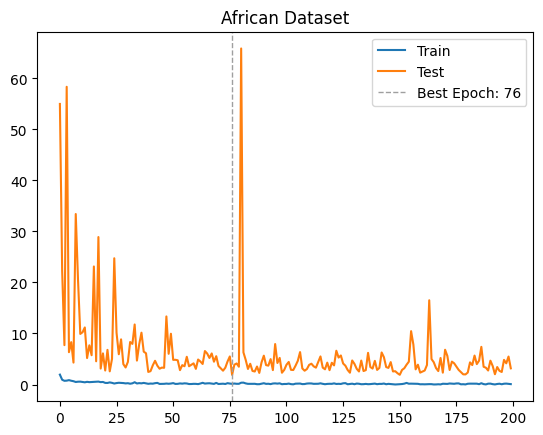

In [ ]:
checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/afr_ckpt.pt'
_, _, _, full_train_losses, full_val_losses = load_model(checkpoint_save_path, device)
title = "African Dataset"
plot_training_curve(full_train_losses, full_val_losses, best_epoch, title)

In [ ]:
image_size = 500
transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])

african_val_dataset = AfricanFetalPlaneDataset("/content/drive/MyDrive/african_dataset/Images",
                                           "/content/drive/MyDrive/african_dataset/African_planes_database.csv",
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")

val_dataloader = DataLoader(african_val_dataset, batch_size=8)

afr_model.eval()
pred_list = []
label_list = []
with torch.no_grad():
  for inputs, labels in val_dataloader:
    inputs = inputs.to(device)
    outputs = afr_model(inputs)
    _, preds = torch.max(outputs, 1)
    pred_list = np.concatenate((pred_list, preds.detach().cpu().numpy()))
    label_list = np.concatenate((label_list, labels))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy: 0.9141630901287554
Precision: [1.         0.88888889 0.96825397 0.75555556]
Recall: [0.95384615 0.86153846 0.953125   0.87179487]
F1: [0.97637795 0.875      0.96062992 0.80952381]
Support: [65 65 64 39]


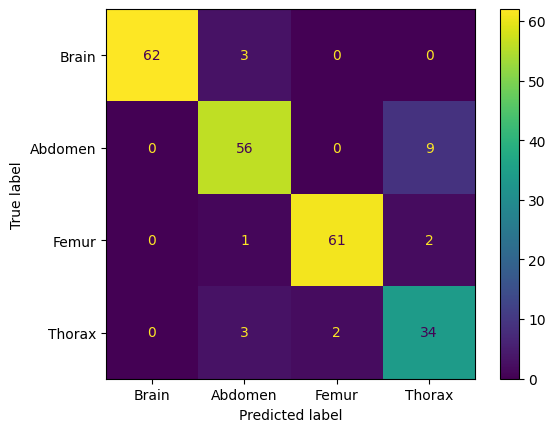

In [ ]:
class_names = ["Brain", "Abdomen", "Femur", "Thorax"]
evaluate_model(label_list, pred_list, class_names)

# Fetal Plane Dataset

## Train

In [ ]:
# !unzip /content/drive/MyDrive/FETAL_PLANES_ZENODO.zip -d /content/drive/MyDrive/fetalplane_dataset

In [ ]:
# image_size = 500
# transform_operations=transforms.Compose([
#                         #mt.RandRotate(range_x=0.1, prob=0.5),
#                         #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
#                         #mt.Resize([image_size, image_size]),
#                         transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
#                         transforms.ToTensor(),
#                         transforms.Resize([image_size, image_size], antialias=True),
#                         transforms.Normalize((0.5), (0.5)),
#                         ])

# fetalplane_train_dataset = FetalPlaneDataset("/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/Images",
#                                            "/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/FETAL_PLANES_DB_data.csv",
#                                            transform=transform_operations,
#                                            return_labels=True,
#                                            split_type="csv",
#                                            split="train")
# fetalplane_test_dataset = FetalPlaneDataset("/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/Images",
#                                            "/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/FETAL_PLANES_DB_data.csv",
#                                            transform=transform_operations,
#                                            return_labels=True,
#                                            split_type="csv",
#                                            split="valid")
# train_size = int(0.9 * len(fetalplane_train_dataset))
# val_size = len(fetalplane_train_dataset) - train_size
# fetalplane_train_dataset, fetalplane_val_dataset = torch.utils.data.random_split(fetalplane_train_dataset, [train_size, val_size])
# print((len(fetalplane_train_dataset), len(fetalplane_val_dataset), len(fetalplane_test_dataset)))

(6416, 713, 5271)


In [3]:
image_size = 128
transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])

brainplane_train_dataset = FetalPlaneDataset("/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/Images",
                                           "/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/FETAL_PLANES_DB_data.csv",
                                           transform=transform_operations,
                                           return_labels=True,
                                           plane='Fetal brain',
                                           split_type="csv",
                                           split="train")
brainplane_val_dataset = FetalPlaneDataset("/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/Images",
                                           "/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/FETAL_PLANES_DB_data.csv",
                                           transform=transform_operations,
                                           return_labels=True,
                                           plane='Fetal brain',
                                           split_type="csv",
                                           split="valid")
# train_size = int(0.9 * len(fetalplane_train_dataset))
# val_size = len(fetalplane_train_dataset) - train_size
# fetalplane_train_dataset, fetalplane_val_dataset = torch.utils.data.random_split(fetalplane_train_dataset, [train_size, val_size])
print((len(brainplane_train_dataset), len(brainplane_val_dataset)))

(1543, 1406)


In [4]:
train_dataloader = DataLoader(brainplane_train_dataset, batch_size=32, shuffle="True")
val_dataloader = DataLoader(brainplane_val_dataset, batch_size=32)

# ims, planes = next(iter(train_dataloader))
# for i, p in list(zip(ims, planes)):
#     plt.imshow(i[0], cmap="gray")
#     plt.title(f"Plane: {p}")
#     plt.show()

In [12]:
bp_model = models.densenet169(pretrained=True)
num_features = bp_model.classifier.in_features
bp_model.fc = nn.Linear(num_features, 3)
bp_model = bp_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bp_model.parameters(), lr=0.001)

In [ ]:
# num_epochs = 200
# model_save_path = '/content/drive/MyDrive/xfetus/models/fp_clf.pt'
# checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/fp_ckpt.pt'

# train_model(train_dataloader,
#             val_dataloader,
#             bp_model,
#             optimizer,
#             num_epochs,
#             model_save_path,
#             checkpoint_save_path,
#             load_checkpoint=False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 0 iteration 0 training loss: 10.482345581054688
Epoch 0 iteration 10 training loss: 1.216278314590454
Epoch 0 iteration 20 training loss: 0.779664158821106
Epoch 0 iteration 30 training loss: 0.6563494801521301
Epoch 0 iteration 40 training loss: 0.5644567608833313
Epoch 0 average training loss: 1.3300513996153462, average validation loss: 1.6598860242150046
Epoch 1 iteration 0 training loss: 0.34682929515838623
Epoch 1 iteration 10 training loss: 0.5704085826873779
Epoch 1 iteration 20 training loss: 0.5011683702468872
Epoch 1 iteration 30 training loss: 0.5863394141197205
Epoch 1 iteration 40 training loss: 0.23061317205429077
Epoch 1 average training loss: 0.4204530071239082, average validation loss: 0.6009019660678777
Epoch 2 iteration 0 training loss: 0.17250566184520721
Epoch 2 iteration 10 training loss: 0.104454904794693
Epoch 2 iteration 20 training loss: 0.41813626885414124
Epoch 2 iteration 30 training loss: 0.35807037353515625
Epoch 2 iteration 40 training loss: 0.243

##Evaluate

In [14]:
model_save_path = '/content/drive/MyDrive/xfetus/models/bp_clf.pt'

bp_model = models.densenet169(pretrained=True)
num_features = bp_model.classifier.in_features
bp_model.fc = nn.Linear(num_features, 3)
bp_model = bp_model.to(device)

best_epoch, model, optimizer, train_losses, val_losses = load_model(model_save_path, device, bp_model)
print(f"Loaded model from best epoch {best_epoch} with validation loss: {val_losses[-1]}")

OrderedDict([('features.conv0.weight', tensor([[[[-1.4180e-02,  3.5166e-02, -5.5300e-02,  ..., -9.1828e-02,
            8.5641e-02, -4.5871e-02],
          [ 2.6644e-02, -1.1431e-01,  8.3740e-02,  ...,  1.2501e-01,
           -1.8556e-01,  8.3895e-02],
          [-4.9485e-02,  6.1735e-02,  3.5322e-02,  ...,  5.6878e-02,
            1.1809e-01, -1.1880e-01],
          ...,
          [-7.4738e-02,  1.6052e-01,  1.4400e-02,  ...,  4.8419e-01,
           -2.4748e-01,  2.8881e-02],
          [ 7.4418e-02, -1.7241e-01,  1.7804e-01,  ..., -2.1661e-01,
            1.4779e-01, -3.4944e-02],
          [-4.0012e-02,  9.0449e-02, -1.2072e-01,  ...,  8.2435e-03,
           -2.5746e-02, -9.6501e-03]],

         [[-3.6082e-02,  3.7363e-02, -7.4441e-02,  ..., -1.0300e-01,
            6.5613e-02, -4.9233e-02],
          [ 4.0288e-02, -1.0590e-01,  8.4644e-02,  ...,  1.7077e-01,
           -1.9411e-01,  9.1187e-02],
          [-6.0680e-02,  6.0371e-02,  2.8468e-02,  ...,  3.6111e-02,
            1.3499e

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


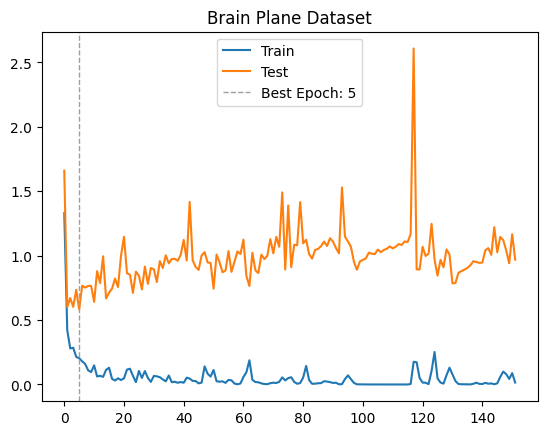

In [19]:
bp_model.eval()
pred_list = []
label_list = []
with torch.no_grad():
  for inputs, labels in val_dataloader:
    inputs = inputs.to(device)
    outputs = bp_model(inputs)
    _, preds = torch.max(outputs, 1)
    pred_list = np.concatenate((pred_list, preds.detach().cpu().numpy()))
    label_list = np.concatenate((label_list, labels))

checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/bp_ckpt.pt'
_, _, _, full_train_losses, full_val_losses = load_model(checkpoint_save_path, device)
title = "Brain Plane Dataset"
plot_training_curve(full_train_losses, full_val_losses, best_epoch, title)

Accuracy: 0.8093883357041252
Precision: [0.84146341 0.70501475 0.8449848 ]
Recall: [0.81176471 0.79139073 0.820059  ]
F1: [0.82634731 0.74570983 0.83233533]
Support: [765 302 339]


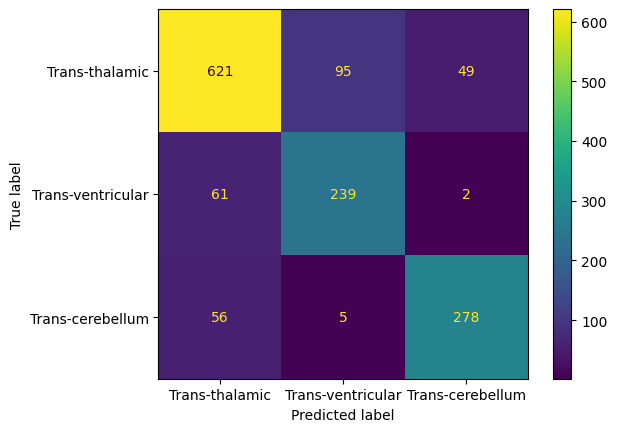

In [20]:
class_names = ['Trans-thalamic', 'Trans-ventricular', 'Trans-cerebellum']
evaluate_model(label_list, pred_list, class_names)